#### Start

#### Required imports for analysis part

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import importlib
impo

In [ ]:
#import pytraj as pt
import nglview as nv

#### Create ligand pdb

In [ ]:
# separates ligand from protein ligand complex and create ligand.pdb file
# change the ligand name wherever needed
ligand = "JZ4"
! grep $ligand protein.pdb > ligand.pdb

#### Remove waters and non-standard residues

In [6]:
# pdb2gmx takes only protein file containing standard amino acid residues,
    # so check the protein file, should contain only standard residues
! grep -v HETATM protein.pdb > protein_processed.pdb

#### 1. Protein topology

In [7]:
# this command prepares protein topology file and sets water model
! printf "1" | gmx pdb2gmx -ignh -f protein_processed.pdb -o protein_processed.gro -water spc

                     :-) GROMACS - gmx pdb2gmx, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mu

In [8]:
! tail topol.top

; Include topology for ions
#include "./charmm36-feb2021.ff/ions.itp"

[ system ]
; Name
Protein

[ molecules ]
; Compound        #mols
Protein_chain_A     1


#### 2. Ligand tolpology

In [9]:
# for ligand toplogy
# 1. convert to mol2 file
# 2. The first change that needs to be made is in the MOLECULE heading. 
#   Replace "*****" with ligand name eg.
#   @<TRIPOS>MOLECULE
#   JZ4
# 3. change number before ligand column to "1" and ligand name in mol2 file
! obabel ligand.pdb -O ligand.mol2 -h

1 molecule converted


In [10]:
# 4. fix bond order with perl script
! perl sort_mol2_bonds.pl ligand.mol2 ligand_fix.mol2

Found 37 atoms in the molecule, with 39 bonds.


In [13]:

# 5. goto cgenFF website and upload the previous mol2 file and get the corresponding .str file. 
    #(cgenFF website is used only if CHARMM36 Forcefield is used)
    #The CHARMM stream file contains all of the topology information - atom types,charges, and bonded connectivity.
# Examine the contents of .str and look at the penalties for the charges and the new dihedral parameters. 
    #All of them are very low, suggesting that this topology is of very good quality 
        #and can be used directly for our simulation.

# 6. Use the cgenff_charmm2gmx.py script that downloaded from the MacKerell website.    
        #Now the ligand topology is ready
# if not works then run in terminal
# Change ligand id in below command - important

! python3 cgenff_charmm2gmx_py3_nx2.py ligand ligand_fix.mol2 ligand_fix.str charmm36-feb2021.ff/

NOTE 1: Code tested with Python 3.5.2 and 3.7.3. Your version: 3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]

NOTE 2: Code tested with NetworkX 2.3. Your version: 2.3

NOTE 3: Please be sure to use the same version of CGenFF in your simulations that was used during parameter generation:
--Version of CGenFF detected in  ligand_fix.str : 4.5
--Version of CGenFF detected in  charmm36-feb2021.ff//forcefield.doc : 4.4



NOTE 4: To avoid duplicated parameters, do NOT select the 'Include parameters that are already in CGenFF' option when uploading a molecule into CGenFF.
============ DONE ============
Conversion complete.
The molecule topology has been written to ligand.itp
Additional parameters needed by the molecule are written to ligand.prm, which needs to be included in the system .top

PLEASE NOTE: If your topology has lone pairs, you must use GROMACS version 2020 or newer to use 2fd construction
Older GROMACS versions WILL NOT WORK as they do not support 2fd virtual site construc

#### Build the Complex - Combine .gro files

In [14]:
# This command creates ligand .gro file
# We have "jz4_ini.pdb" from cgenff_charmm2gmx.py that has all of the necessary H atoms 
    #and matches the atom names in the ligand topology. Convert this .pdb file to .gro format with editconf
# Change the input file name in below command - important
! gmx editconf -f ligand_ini.pdb -o ligand.gro

                     :-) GROMACS - gmx editconf, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu M

In [ ]:
# now we have .gro files for protein and ligand so combine them into one file

# Copy protein_processed.gro to a new file "complex.gro,"
# Next, copy jz4.gro and paste it into "complex.gro", below the last line of the protein atoms, 
    #and before the box vectors 
# 5.99500   5.19182   9.66100   0.00000   0.00000  -2.99750   0.00000   0.00000   0.00000
# increment the second line of complex.gro and add number of ligand atoms to reflect this change.

#### Build the Topology - combine topology files

In [ ]:
# 1. insert a line #include "ligand.itp" into topol.top after the position restraint file is included. 
#    The inclusion of position restraints indicates the end of the "Protein" moleculetype section.
# 2. The ligand introduces new dihedral parameters, which were written to "ligand.prm" by the cgenff_charmm2gmx.py script
    #so At the TOP of topol.top, insert an #include "ligand.prm" statement,
    #after #include "./charmm36-mar2019.ff/forcefield.itp" forcefield parameters
# 3. The last adjustment to be made is in the [ molecules ] directive. 
    #To account for the fact that there is a new molecule in complex.gro, we have to add it here, like so:
#    ligand        1

# The topology and coordinate file are now in agreement with respect to the contents of the system.

#### 3. Defining the Unit Cell & Adding Solvent

In [15]:
# c- center, d-distance from box edge also centers the system, bt-box type
! gmx editconf -f complex.gro -o complex_box.gro -bt dodecahedron -d 1.0

! gmx solvate -cp complex_box.gro -cs spc216.gro -p topol.top -o complex_solv.gro
# cp - protein conf, cs - solute conf
# if you want you can visualize complex_solv.gro


                     :-) GROMACS - gmx editconf, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu M

#### 4. Adding Ions

In [16]:
! gmx grompp -f ions.mdp -c complex_solv.gro -p topol.top -o ions.tpr
# gromacs preprocessor to create binary file(.tpr)
# f - grompp input file with MD parameters(.mdp file)

                      :-) GROMACS - gmx grompp, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mu

In [17]:
# We now pass our .tpr file to genion
! printf "15" | gmx genion -s ions.tpr -o complex_solv_ions.gro -p topol.top -pname NA -nname CL -neutral
# The specified atom names are always the elemental symbol in all capital letters, along with the [ moleculetype]. 
    #Residue names may or may not append the sign 1of the charge (+/-). 
    #Refer to ions.itp for proper nomenclature if you encounter difficulties.

                      :-) GROMACS - gmx genion, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mu

In [18]:
# check Your [ molecules ] directive for ions
! tail topol.top

[ system ]
; Name
Protein in water

[ molecules ]
; Compound        #mols
Protein_chain_A 1
ligand  1
SOL         604602
NA               24


#### 5. Energy Minimization

In [26]:
! gmx grompp -f em.mdp -c complex_solv_ions.gro -p topol.top -o em.tpr

! gmx mdrun -v -deffnm em
# ! gmx mdrun -v -deffnm em -nt 8 &
# ampersand used to continue running even the shell is closed in linux shells in general

                      :-) GROMACS - gmx grompp, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mu

Step=   16, Dmax= 1.5e-01 nm, Epot=  1.46252e+08 Fmax= 1.69448e+07, atom= 577418
Step=   17, Dmax= 1.8e-01 nm, Epot=  1.42559e+08 Fmax= 6.91169e+06, atom= 7758
Step=   19, Dmax= 1.1e-01 nm, Epot=  1.37958e+08 Fmax= 8.18854e+07, atom= 572042
Step=   20, Dmax= 1.3e-01 nm, Epot=  1.37372e+08 Fmax= 6.52219e+06, atom= 7758
Step=   21, Dmax= 1.6e-01 nm, Epot=  1.30040e+08 Fmax= 1.83704e+07, atom= 7758
Step=   22, Dmax= 1.9e-01 nm, Epot=  1.27550e+08 Fmax= 3.03149e+07, atom= 475580
Step=   23, Dmax= 2.3e-01 nm, Epot=  1.24546e+08 Fmax= 6.72917e+06, atom= 476414
Step=   25, Dmax= 1.4e-01 nm, Epot=  1.18699e+08 Fmax= 6.19405e+06, atom= 775862
Step=   27, Dmax= 8.3e-02 nm, Epot=  1.16535e+08 Fmax= 1.35138e+08, atom= 571862
Step=   28, Dmax= 9.9e-02 nm, Epot=  1.15641e+08 Fmax= 5.93854e+06, atom= 7750
Step=   29, Dmax= 1.2e-01 nm, Epot=  1.11458e+08 Fmax= 5.77270e+07, atom= 475766
Step=   30, Dmax= 1.4e-01 nm, Epot=  1.10701e+08 Fmax= 6.00278e+06, atom= 7758
Step=   32, Dmax= 8.6e-02 nm, Epot=  1

#### View potential graph of Energy minimisation

In [23]:
# view potential after energy minimization
# run in terminal
! printf "11" | gmx energy -f em.edr -o potential.xvg

                      :-) GROMACS - gmx energy, 2021.2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teemu Mu

Text(0, 0.5, 'potential')

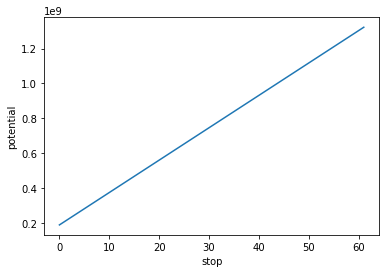

In [24]:
potential = np.genfromtxt([i for i in open('potential.xvg').read().splitlines() 
    if not i.startswith(('#','@'))])

plt.plot(*potential.T)
plt.xlabel('stop')
plt.ylabel('potential')

#### 6. Equilibration

In [ ]:
# There are a few special considerations, in this case:

# 1. Applying restraints to the ligand
# 2. Treatment of temperature coupling groups

##### Restraining the Ligand

In [ ]:
# Run in terminal

# To restrain the ligand, we will need to generate a position restraint topology for it. 
#    First, create an index group for JZ4 that contains only its non-hydrogen atoms:
! gmx make_ndx -f ligand.gro -o index_ligand.ndx
# ...
# > 0 & ! a H*
# > q
# 

In [ ]:
# Run in terminal

# Then, execute the genrestr module and give this newly created index group 
    #(which will be group 3 in the index_jz4.ndx file)

! printf "3" | gmx genrestr -f ligand.gro -n index_ligand.ndx -o posre_jz4.itp -fc 1000 1000 1000

In [ ]:
# Now, we need to include this information in our topology. 
    #We can do this in several ways, depending upon the conditions we wish to use. 
    #If we simply want to restrain the ligand whenever the protein is also restrained, 
    #add the following lines to your topology in the location indicated


In [ ]:
---> ; Include Position restraint file
#ifdef POSRES
#include "posre.itp"
#endif

; Include ligand topology
#include "jz4.itp"

; Include water topology
#include "./charmm36-mar2019.ff/tip3p.itp"

##### Thermostats

In [ ]:
# Run in terminal
# Coupling every moleculetype to its own thermostatting group is a bad idea. For instance, if you do the following:
    #tc-grps = Protein JZ4 SOL CL
    # Your system will probably blow up, since the temperature coupling algorithms
    #are not stable enough to control the fluctuations in kinetic energy that groups with a few atoms 
    #(i.e., JZ4 and CL) will produce. Do not couple every single species in your system separately.

# create an index which contain protein and ligand for the purpose of thermostats
    # this is for temperature coupling 
! gmx make_ndx -f em.gro -o Protein_LK01.ndx
# > 1 | 13
# > q


##### NVT equilibration

In [ ]:
# ampersand may be used to continue running even the shell is closed in linux shells in general
! gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -n Protein_LK01 -o nvt.tpr
#! gmx mdrun -v -deffnm nvt

In [ ]:
# ! gmx mdrun -v -deffnm nvt -cpi nvt.cpt -nt 6
# if md run is interruprted then uncomment and excecute this cell to continue operation 

#### view Temperature graph after NVT equilibration

In [ ]:
# Preferably run in terminal
! printf "15 0" | gmx energy -f nvt.edr -o temperature.xvg 

In [ ]:
temperature = np.genfromtxt([i for i in open('temperature.xvg').read().splitlines() 
    if not i.startswith(('#','@'))]) 

plt.plot(*temperature.T)
plt.xlabel('stop')
plt.ylabel('temperature')

##### 7. NPT equilibration

In [ ]:
# ampersand may be used to continue running even the shell is closed in linux shells in general
! gmx grompp -f npt.mdp -c nvt.gro -t nvt.cpt -r nvt.gro -p topol.top -n index_protein_ligand.ndx -o npt.tpr
! gmx mdrun -v -deffnm npt

In [ ]:
# if md run is interruprted continue operation like previous command

#### View Pressure and Density graph after NVT equilibration

In [ ]:
# Preferably run in terminal
! printf "17 0" | gmx energy -f npt.edr -o pressure.xvg 

In [ ]:
pressure = np.genfromtxt([i for i in open('pressure.xvg').read().splitlines() 
    if not i.startswith(('#','@'))])

plt.plot(*pressure.T)
plt.xlabel('stop')
plt.ylabel('pressure')

In [ ]:
# Preferably run in terminal
! printf "24 0" | gmx energy -f npt.edr -o density.xvg 

In [ ]:
density = np.genfromtxt([i for i in open('density.xvg').read().splitlines() 
    if not i.startswith(('#','@'))]) 

plt.plot(*density.T)
plt.xlabel('stop')
plt.ylabel('density')

#### 8. Production MD

In [ ]:
# ampersand may be used to continue running even the shell is closed in linux shells in general
! gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -n index.ndx -o md.tpr
! gmx mdrun -v -deffnm md

# if md run is interruprted continue operation like previous command

#### 9. Analysis

#### Removing periodicities in the trajectories

In [ ]:
# correct trajectory of nvt
# when prompted give 1,1 for protein only or 0,0 for System itself
# change printf statement if you want

! printf "System \n System \n" | gmx trjconv -s nvt.tpr -f nvt.xtc -o nvt_corrected.xtc -pbc mol -ur compact -center


In [ ]:
# correct trajectory of npt
# when prompted give 1,1 for Protein only or 0,0 for system itself
# change printf statement if you want

! printf "Protein \n Protein \n" | gmx trjconv -s npt.tpr -f npt.xtc -o npt_corrected.xtc -pbc mol -ur compact -center


In [ ]:
# correct trajectory of md
# when prompted give 1,1 for protein only or 0,0 for System itself
# change printf statement if you want

! printf "System \n System \n" | gmx trjconv -s md.tpr -f md.xtc -o md_corrected.xtc -pbc mol -ur compact -center

In [ ]:
# For even smoother visualization, it may be beneficial to perform rotational and translational fitting. Execute trjconv as follows:
# Choose "Backbone" to perform least-squares fitting to the protein backbone, and "System" for output. 
# change printf statement if you want

! printf "Backbone \n System \n" | gmx trjconv -s md.tpr -f md_corrected.xtc -o md_fit.xtc -fit rot+trans

#### RMSD, RMSF, Gyrate, HBonds

In [ ]:
# RMSD: Root Mean Square Deviation
# Enter what w.r.t what
# change printf statement
# when prompted give 4,4 for Backbone

! printf "Backbone \n Backbone \n" | gmx rms -s md.tpr -f md_corrected.xtc -o rmsd.xvg

xvg_file = np.genfromtxt([i for i in open("rmsd.xvg").read().splitlines() 
    if not i.startswith(('#','@'))]) 
plt.plot(*xvg_file.T)

In [ ]:
# RMSF: Root Mean Square Fluctuation
# Enter what w.r.t what
# change printf statement
# when prompted give 3,3 for C-alpha

! printf "C-alpha \n C-alpha \n" | gmx rmsf -s md.tpr -f md_corrected.xtc -o rmsf.xvg -res 

xvg_file = np.genfromtxt([i for i in open("rmsf.xvg").read().splitlines() 
    if not i.startswith(('#','@'))]) 
plt.plot(*xvg_file.T)

In [ ]:
# Gyrate: Radius of Gyration
# when prompted give 1,1 for Protein 

! printf "Protein \n Protein \n" | gmx gyrate -s md_corrected.xtc -f md_corrected.xtc -o gyration.xvg

xvg_file = np.genfromtxt([i for i in open("gyration.xvg").read().splitlines() 
    if not i.startswith(('#','@'))]) 
plt.plot(*xvg_file.T)

In [ ]:
# hbonds: Hydrogen Bonds
# Enter what w.r.t what
# change printf statement
# when prompted give 1,1 for Protein

! printf "Protein \n Protein \n" | gmx hbond -s md.tpr -f md_corrected.xtc -num hbond.xvg

xvg_file = np.genfromtxt([i for i in open("hbond.xvg").read().splitlines() 
    if not i.startswith(('#','@'))]) 
plt.plot(*xvg_file.T)